In [1]:
#import sys
#sys.path.insert(0,"/workspace/bt")

import yfinance as yf
import matplotlib.pyplot as plt
from strategy import *

%matplotlib inline

bt version :  (0, 2, 9)


In [2]:
tickers = ['TQQQ','TMF']
dualtickers = ['BND','BIL']

# 월초 리밸런싱
run_on_end_of_period = False
# 지연시간 1일, 하루전 종가 기준으로 리밸런싱
lag = 1
resample_monthly = False


In [3]:
data = yf.download(tickers+dualtickers)['Adj Close']
data = data[tickers+dualtickers]
for c in data.columns:
    print(c, data[c].first_valid_index())
assets = data.dropna().copy()

if resample_monthly:
    assets = assets.resample('M').last().dropna()
    lag = 0
    
start_day = assets.index.min() + pd.DateOffset(months=12) - pd.DateOffset(days=1)
print('asset \n', assets)
print('start day : ', start_day)

[*********************100%***********************]  4 of 4 completed
TQQQ 2010-02-11 00:00:00
TMF 2009-04-16 00:00:00
BND 2007-04-10 00:00:00
BIL 2007-05-30 00:00:00
asset 
                  TQQQ        TMF        BND        BIL
Date                                                  
2010-02-11   0.431471   6.695425  55.449631  86.560013
2010-02-12   0.433238   6.771190  55.526726  86.560013
2010-02-16   0.450019   6.831800  55.596794  86.560013
2010-02-17   0.457656   6.613164  55.470684  86.503426
2010-02-18   0.466332   6.500601  55.393600  86.541153
...               ...        ...        ...        ...
2022-12-01  23.690001   9.280000  73.199997  91.430000
2022-12-02  23.410000   9.610000  73.500000  91.440002
2022-12-05  22.230000   9.230000  72.919998  91.449997
2022-12-06  20.820000   9.590000  73.160004  91.480003
2022-12-07  20.570000  10.230000  73.800003  91.480003

[3229 rows x 4 columns]
start day :  2011-02-10 00:00:00


In [4]:
# 매수&보유 백테스트
def long_only_ew(assets, start_day, name='long_only_ew'):
    s = bt.Strategy(name, [bt.algos.RunOnce(),
                           bt.algos.SelectAll(),
                           bt.algos.WeighEqually(),
                           bt.algos.Rebalance()])
    return bt.Backtest(s, assets, initial_capital=100000000.0)

Stat                 benchmark(TQQQ)
-------------------  -----------------
Start                2011-02-10
End                  2022-12-07
Risk-free rate       0.00%

Total Return         2130.61%
Daily Sharpe         0.74
Daily Sortino        1.16
CAGR                 30.03%
Max Drawdown         -80.64%
Calmar Ratio         0.37

MTD                  -12.69%
3m                   -25.50%
6m                   -38.28%
YTD                  -75.27%
1Y                   -75.43%
3Y (ann.)            2.52%
5Y (ann.)            13.07%
10Y (ann.)           34.63%
Since Incep. (ann.)  30.03%

Daily Sharpe         0.74
Daily Sortino        1.16
Daily Mean (ann.)    45.84%
Daily Vol (ann.)     62.02%
Daily Skew           -0.40
Daily Kurt           6.39
Best Day             26.99%
Worst Day            -34.47%

Monthly Sharpe       0.77
Monthly Sortino      1.44
Monthly Mean (ann.)  40.98%
Monthly Vol (ann.)   53.35%
Monthly Skew         -0.14
Monthly Kurt         0.26
Best Month           46.45%
W

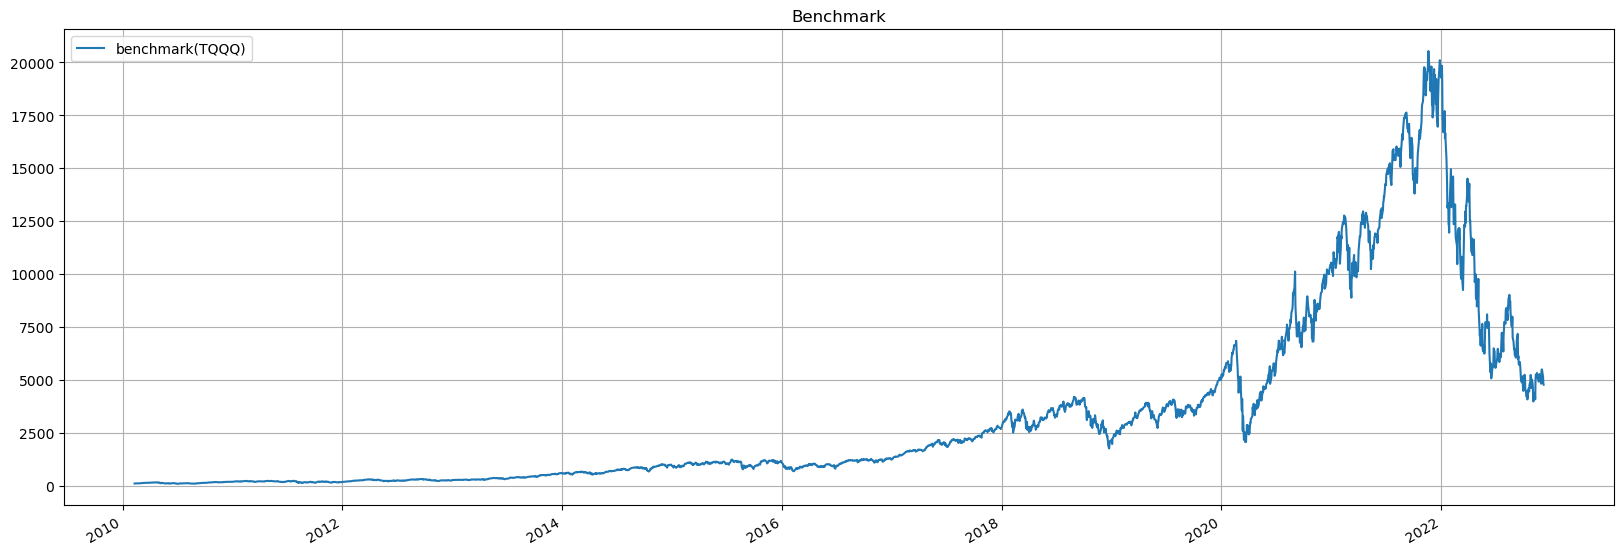

In [5]:
# 벤치마크 수익율
benchmark = long_only_ew(assets[tickers[0]].to_frame(), start_day, 'benchmark({})'.format(tickers[0]))
report = bt.run(benchmark)

report.plot(figsize=(20,7), grid=True, title="Benchmark")
print(report.prices[start_day:].calc_stats().display())

In [6]:
# 상대모멘텀 백테스트
def RelativeMomentum_BT(assets, rank, months, start_day, run_on_end_of_period=False, lag=1, name='Relative Momentum'):
    s = bt.Strategy(name, [bt.algos.RunAfterDate(start_day),
                           bt.algos.RunMonthly(run_on_first_date=False, run_on_end_of_period=run_on_end_of_period, run_on_last_date=False),
                           #bt.algos.PrintInfo('{name}:{now}. Value:{_value:0.0f}, Price:{_price:0.4f}'),
                           #bt.algos.PrintDate(),
                           SelectRelativeMomentum(rank=rank, lookback=pd.DateOffset(months=months), lag=pd.DateOffset(days=lag)),
                           bt.algos.WeighEqually(),
                           #bt.algos.PrintTempData(),
                           bt.algos.Rebalance()])
    return bt.Backtest(s, assets, initial_capital=100000000.0)

In [7]:
# 상대모멘텀 상위 1종목 (1~12개월 비교)
relativemomentum = {}
for i in range(0, 12):
    relativemomentum[i] = RelativeMomentum_BT(assets[tickers], 1, i+1, start_day, False, lag, name='RM({})'.format(str(i+1)))
    
rm1_report = bt.run(*relativemomentum.values())

<AxesSubplot:title={'center':'Relative Momentum (1~12 month) with rank 1'}>

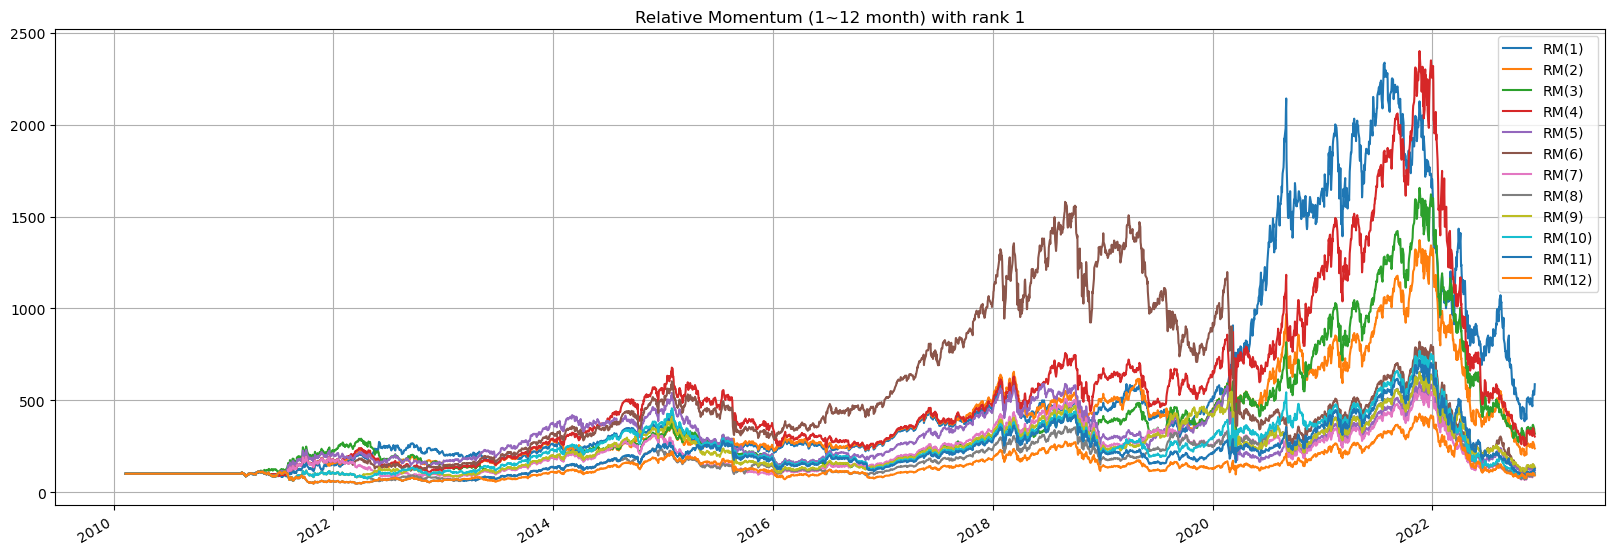

In [8]:
rm1_report.plot(figsize=(20,7), grid=True, title="Relative Momentum (1~12 month) with rank 1")

In [9]:
print(rm1_report.prices[start_day:].calc_stats().display())

Stat                 RM(1)       RM(2)       RM(3)       RM(4)       RM(5)       RM(6)       RM(7)       RM(8)       RM(9)       RM(10)      RM(11)      RM(12)
-------------------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------
Start                2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10
End                  2022-12-07  2022-12-07  2022-12-07  2022-12-07  2022-12-07  2022-12-07  2022-12-07  2022-12-07  2022-12-07  2022-12-07  2022-12-07  2022-12-07
Risk-free rate       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%

Total Return         487.42%     137.62%     218.14%     202.48%     17.04%      30.75%      0.89%       4.79%       32.12%      -6.65%      26.62%      -9.31%
Daily Sharpe         0.55   

In [10]:
# 절대모멘텀 백테스트
def AbsoluteMomentum_BT(assets, rank, months, start_day, run_on_end_of_period=False, lag=1, name='Absolute Momentum'):
    s = bt.Strategy(name, [bt.algos.RunAfterDate(start_day),
                           bt.algos.RunMonthly(run_on_first_date=False, run_on_end_of_period=run_on_end_of_period, run_on_last_date=False),
                           #bt.algos.PrintInfo('{name}:{now}. Value:{_value:0.0f}, Price:{_price:0.4f}'),
                           #bt.algos.PrintDate(),
                           SelectAbsoluteMomentum(rank=rank, lookback=pd.DateOffset(months=months), lag=pd.DateOffset(days=lag)),
                           bt.algos.WeighEqually(),
                           #bt.algos.PrintTempData(),
                           bt.algos.Rebalance()])
    return bt.Backtest(s, assets, initial_capital=100000000.0)

In [11]:
# 절대모멘텀 상위 1종목 (1~12개월 비교)
absolutemomentum = {}
for i in range(0, 12):   
    absolutemomentum[i] = AbsoluteMomentum_BT(assets[tickers], 1, i+1, start_day, False, lag, name='AM({})'.format(str(i+1)))
    
am1_report = bt.run(*absolutemomentum.values())

<AxesSubplot:title={'center':'Absolute Momentum(1~12 months) with rank 1'}>

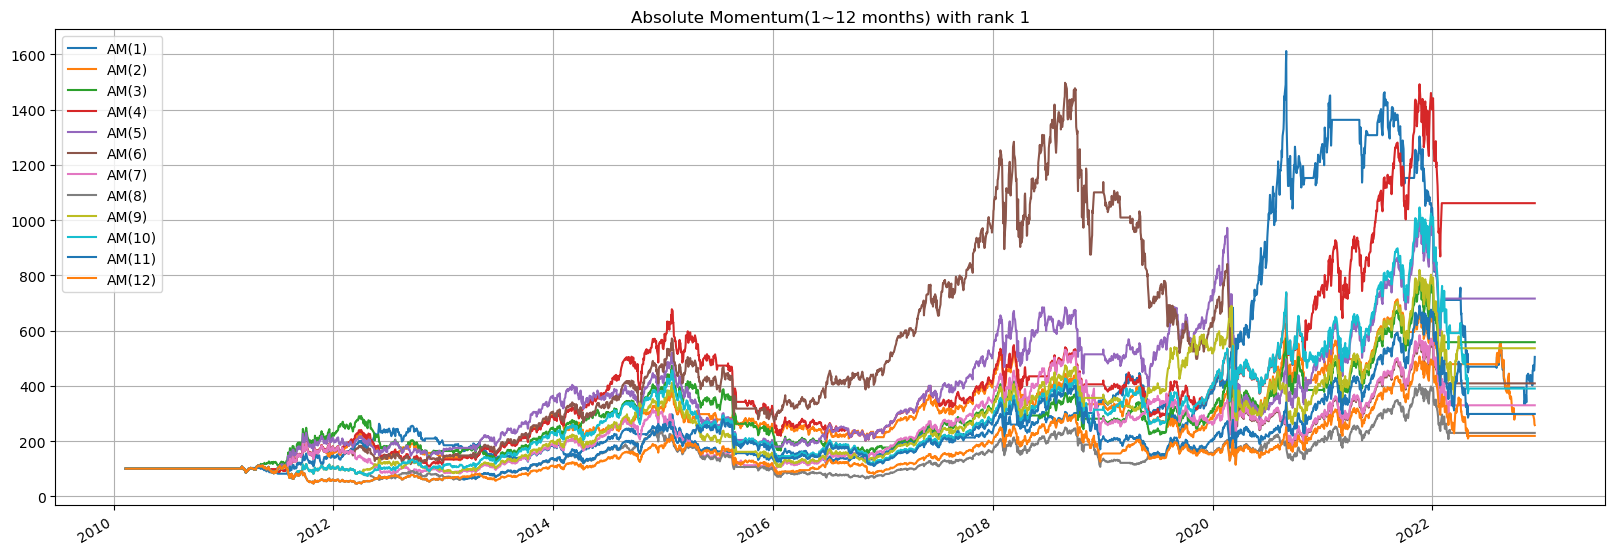

In [12]:
am1_report.plot(figsize=(20,7), grid=True, title='Absolute Momentum(1~12 months) with rank 1')

In [13]:
print(am1_report.prices[start_day:].calc_stats().display())

Stat                 AM(1)       AM(2)       AM(3)       AM(4)       AM(5)       AM(6)       AM(7)       AM(8)       AM(9)       AM(10)      AM(11)      AM(12)
-------------------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------
Start                2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10
End                  2022-12-07  2022-12-07  2022-12-07  2022-12-07  2022-12-07  2022-12-07  2022-12-07  2022-12-07  2022-12-07  2022-12-07  2022-12-07  2022-12-07
Risk-free rate       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%

Total Return         404.75%     157.70%     458.03%     961.31%     615.92%     308.90%     229.57%     129.51%     436.13%     290.18%     198.17%     118.73%
Daily Sharpe         0.53  

In [14]:
# 절대모멘텀 상위 2종목 (1~12개월 비교)
absolutemomentum = {}
for i in range(0, 12):
    absolutemomentum[i] = AbsoluteMomentum_BT(assets[tickers], 2, i+1, start_day, False, lag, name='AM({})'.format(str(i+1)))
    
am2_report = bt.run(*absolutemomentum.values())

<AxesSubplot:title={'center':'Absolute Momentum (1~12 month) with rank 2'}>

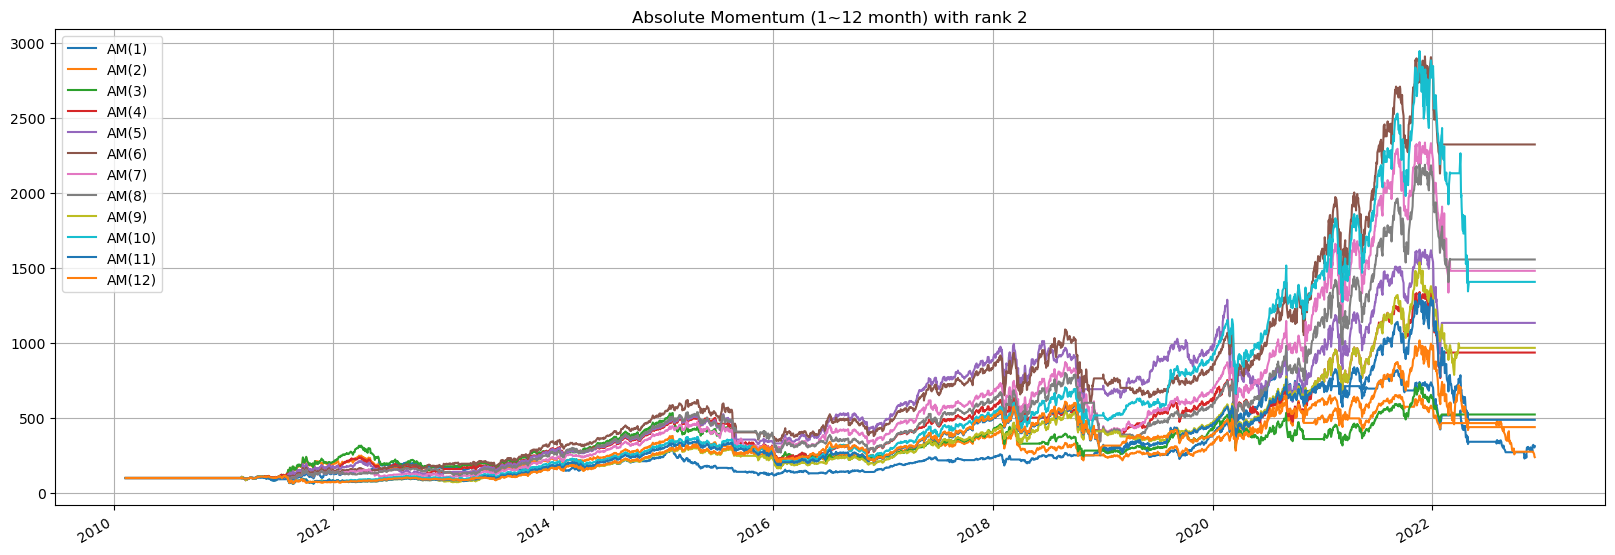

In [15]:
am2_report.plot(figsize=(20,7), grid=True, title='Absolute Momentum (1~12 month) with rank 2')

In [16]:
print(am2_report.prices[start_day:].calc_stats().display())

Stat                 AM(1)       AM(2)       AM(3)       AM(4)       AM(5)       AM(6)       AM(7)       AM(8)       AM(9)       AM(10)      AM(11)      AM(12)
-------------------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------
Start                2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10
End                  2022-12-07  2022-12-07  2022-12-07  2022-12-07  2022-12-07  2022-12-07  2022-12-07  2022-12-07  2022-12-07  2022-12-07  2022-12-07  2022-12-07
Risk-free rate       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%

Total Return         212.52%     138.98%     423.27%     835.98%     1033.71%    2222.81%    1380.74%    1456.29%    867.39%     1307.03%    387.87%     339.21%
Daily Sharpe         0.44  

In [17]:
# 듀얼모멘텀 백테스트
def DualMomentum_BT(assets, rank, months, start_day, run_on_end_of_period=False, lag=1, name='Dual Momentum'):
    s = bt.Strategy(name, [bt.algos.RunAfterDate(start_day),
                           bt.algos.RunMonthly(run_on_first_date=False, run_on_end_of_period=run_on_end_of_period, run_on_last_date=False),
                           #bt.algos.PrintInfo('{name}:{now}. Value:{_value:0.0f}, Price:{_price:0.4f}'),
                           #bt.algos.PrintDate(),
                           SelectDualMomentum(rank=rank, lookback=pd.DateOffset(months=months), lag=pd.DateOffset(days=lag)),
                           bt.algos.WeighEqually(),
                           #bt.algos.PrintTempData(),
                           bt.algos.Rebalance()])
    return bt.Backtest(s, assets, initial_capital=100000000.0)

In [18]:
# 듀얼모멘텀 상위 1종목 (1~12개월 비교)
dualmomentums = {}
for i in range(0, 12):
    dualmomentums[i] = DualMomentum_BT(assets, 1, i+1, start_day, False, lag, name='ODM({})'.format(str(i+1)))

dm1_report = bt.run(*dualmomentums.values())

<AxesSubplot:title={'center':'Dual Momentum (1~12 months) with rank 1'}>

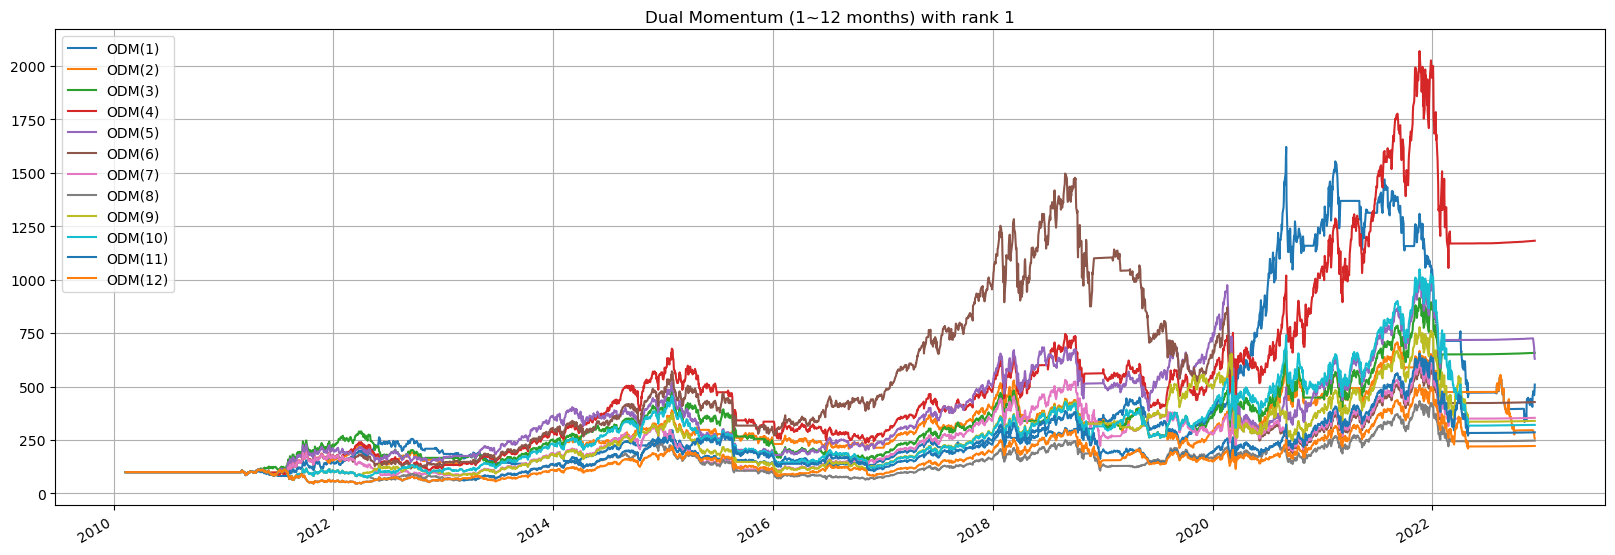

In [19]:
dm1_report.plot(figsize=(20,7), grid=True, title='Dual Momentum (1~12 months) with rank 1')

In [20]:
print(dm1_report.prices[start_day:].calc_stats().display())

Stat                 ODM(1)      ODM(2)      ODM(3)      ODM(4)      ODM(5)      ODM(6)      ODM(7)      ODM(8)      ODM(9)      ODM(10)     ODM(11)     ODM(12)
-------------------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------
Start                2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10
End                  2022-12-07  2022-12-07  2022-12-07  2022-12-07  2022-12-07  2022-12-07  2022-12-07  2022-12-07  2022-12-07  2022-12-07  2022-12-07  2022-12-07
Risk-free rate       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%

Total Return         409.20%     157.15%     557.53%     1081.65%    529.71%     327.37%     253.68%     147.09%     239.44%     220.67%     185.98%     122.11%
Daily Sharpe         0.53 

In [21]:
# 듀얼모멘텀 상위 2종목 (1~12개월 비교)
dualmomentums = {}
for i in range(0, 12):
    dualmomentums[i] = DualMomentum_BT(assets, 2, i+1, start_day, False, lag, name='ODM({})'.format(str(i+1)))

dm2_report = bt.run(*dualmomentums.values())

<AxesSubplot:title={'center':'Dual Momentum (1~12 months) with rank 2'}>

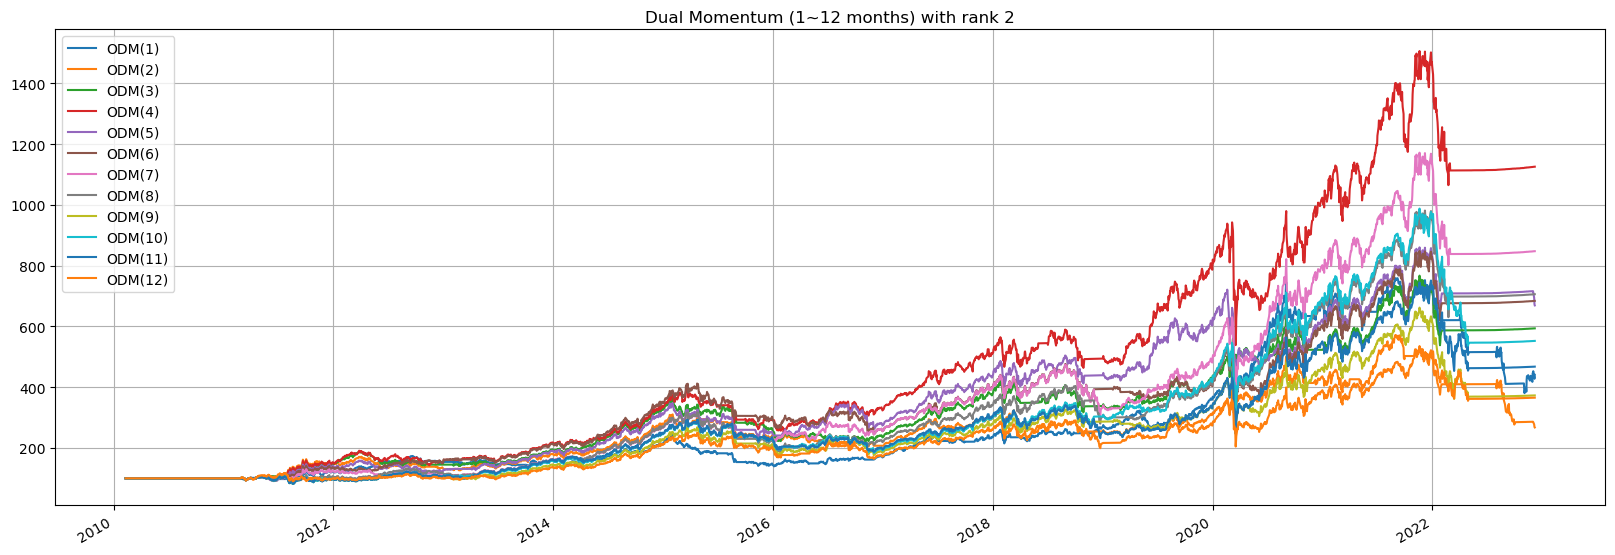

In [22]:
dm2_report.plot(figsize=(20,7), grid=True, title='Dual Momentum (1~12 months) with rank 2')

In [23]:
print(dm2_report.prices[start_day:].calc_stats().display())

Stat                 ODM(1)      ODM(2)      ODM(3)      ODM(4)      ODM(5)      ODM(6)      ODM(7)      ODM(8)      ODM(9)      ODM(10)     ODM(11)     ODM(12)
-------------------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------
Start                2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10
End                  2022-12-07  2022-12-07  2022-12-07  2022-12-07  2022-12-07  2022-12-07  2022-12-07  2022-12-07  2022-12-07  2022-12-07  2022-12-07  2022-12-07
Risk-free rate       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%

Total Return         340.66%     167.39%     493.57%     1025.80%    569.23%     583.98%     747.63%     605.97%     272.82%     452.26%     367.57%     265.39%
Daily Sharpe         0.65 

In [4]:
assets_cash = assets[tickers].copy()
# 1년을 252 영업일로 가정
assets_cash['cash'] = pow(1.03, 1/252)
assets_cash['cash'] = assets_cash['cash'].shift(1, fill_value=1.0)
assets_cash['cash'] = assets_cash['cash'].cumprod()
print(assets_cash)

                 TQQQ        TMF      cash
Date                                      
2010-02-11   0.431471   6.695425  1.000000
2010-02-12   0.433238   6.771190  1.000117
2010-02-16   0.450019   6.831800  1.000235
2010-02-17   0.457656   6.613164  1.000352
2010-02-18   0.466332   6.500601  1.000469
...               ...        ...       ...
2022-12-01  23.690001   9.280000  1.459604
2022-12-02  23.410000   9.610000  1.459775
2022-12-05  22.230000   9.230000  1.459946
2022-12-06  20.820000   9.590000  1.460117
2022-12-07  20.570000  10.230000  1.460289

[3229 rows x 3 columns]


In [9]:
# 평균모멘텀 스코어 백테스트
def AverageMomentum_BT(assets, months, start_day, run_on_end_of_period=False, lag=1, cash_weight=0, name='Average Momentum'):
    s = bt.Strategy(name, [bt.algos.RunAfterDate(start_day),
                           bt.algos.RunMonthly(run_on_first_date=False, run_on_end_of_period=run_on_end_of_period, run_on_last_date=False),
                           #bt.algos.PrintInfo('{name}:{now}. Value:{_value:0.0f}, Price:{_price:0.4f}'),
                           #bt.algos.PrintDate(),
                           bt.algos.SelectAll(),
                           WeighAMSwithCash(lookback=months, lag=lag, cash_weight=cash_weight),
                           #bt.algos.PrintTempData(),
                           bt.algos.Rebalance()])
    return bt.Backtest(s, assets, initial_capital=100000000.0)

In [19]:
# 평균모멘텀 
averagemomentums = {}
cash_weights = [0, 0.3, 0.6]
for i in range(0, len(cash_weights)):
    averagemomentums[i] = AverageMomentum_BT(assets_cash, 12, start_day, False, lag, cash_weights[i], 'AMS_CASH({})'.format(cash_weights[i]))
    
avg_report = bt.run(*averagemomentums.values())

<AxesSubplot:title={'center':'Average Momentum'}>

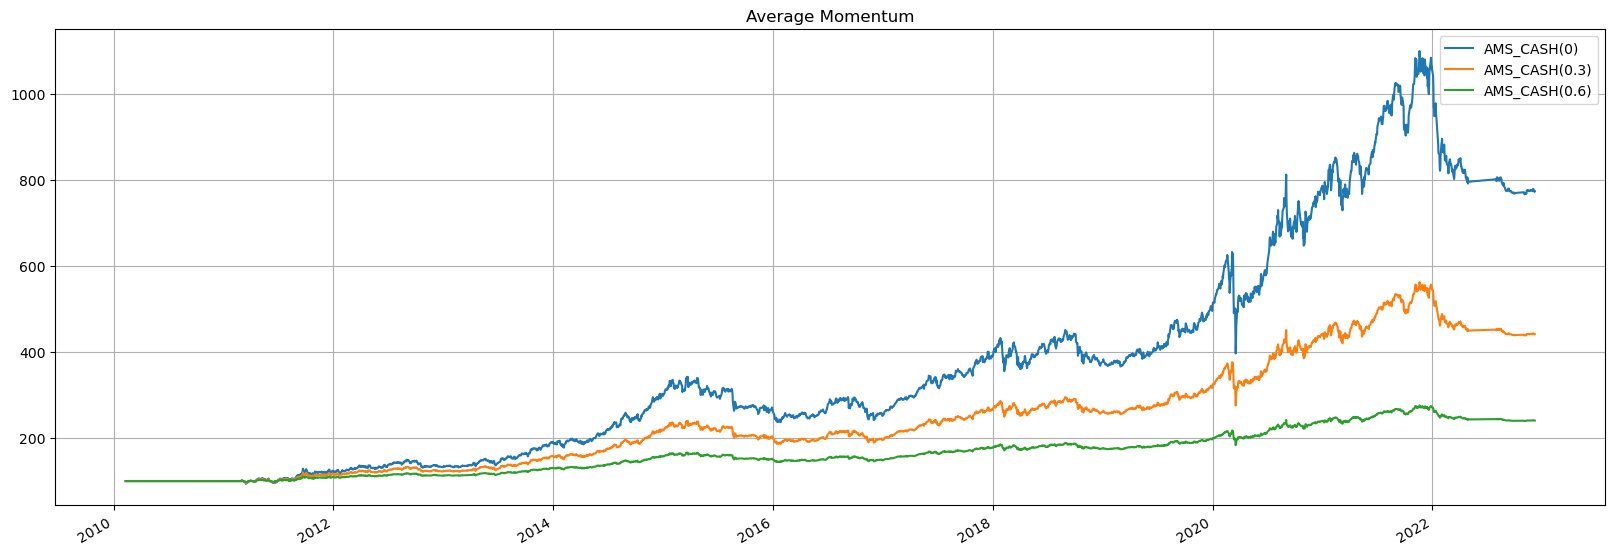

In [20]:
avg_report.plot(figsize=(20,7), grid=True, title='Average Momentum')

In [8]:
avg_report.prices[start_day:].calc_stats().display()

Stat                 Average Momentum
-------------------  ------------------
Start                2011-02-10
End                  2022-12-07
Risk-free rate       0.00%

Total Return         673.19%
Daily Sharpe         0.88
Daily Sortino        1.36
CAGR                 18.89%
Max Drawdown         -37.30%
Calmar Ratio         0.51

MTD                  -0.59%
3m                   -0.30%
6m                   -3.05%
YTD                  -26.58%
1Y                   -28.36%
3Y (ann.)            17.64%
5Y (ann.)            15.23%
10Y (ann.)           19.07%
Since Incep. (ann.)  18.89%

Daily Sharpe         0.88
Daily Sortino        1.36
Daily Mean (ann.)    19.93%
Daily Vol (ann.)     22.76%
Daily Skew           -0.69
Daily Kurt           6.46
Best Day             9.15%
Worst Day            -13.12%

Monthly Sharpe       0.97
Monthly Sortino      1.98
Monthly Mean (ann.)  19.35%
Monthly Vol (ann.)   19.90%
Monthly Skew         0.02
Monthly Kurt         0.37
Best Month           16.37%
Wors

<AxesSubplot:>

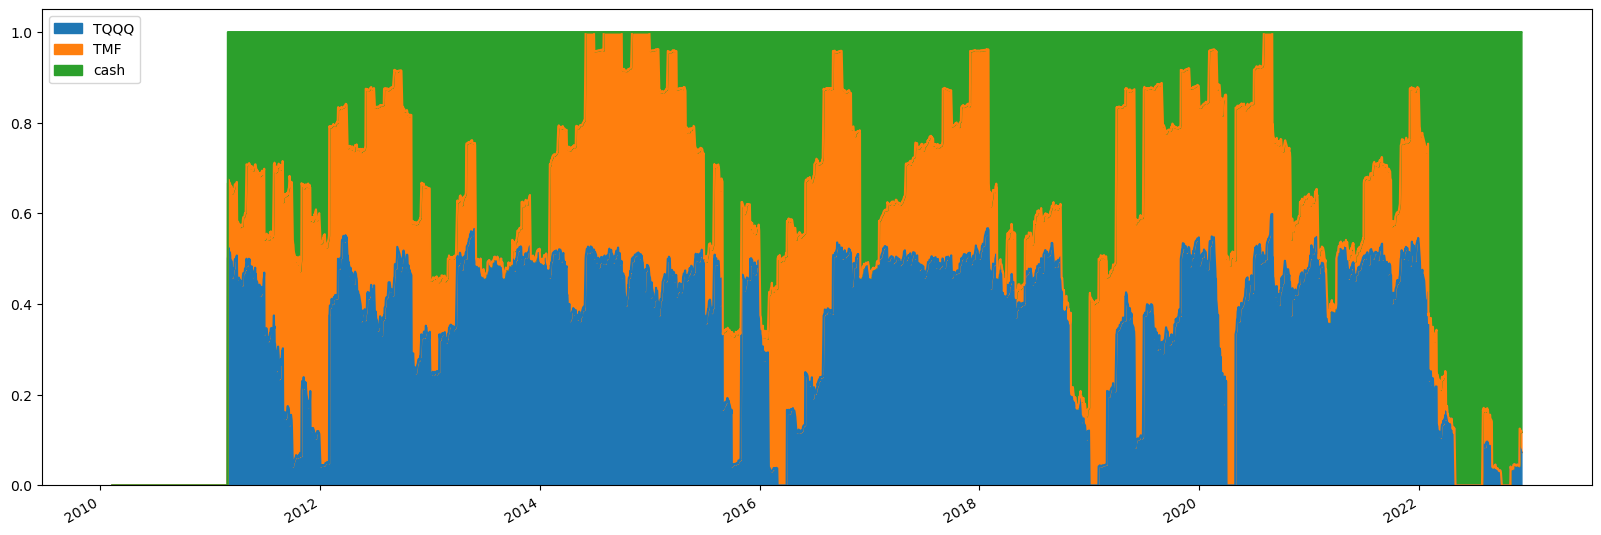

In [29]:
avg_report.get_security_weights().plot.area(figsize=(20,7))

In [30]:
# 변동성역가중 백테스트(일간데이터)
def WeighInvVol_BT(assets, months, start_day, run_on_end_of_period=False, lag=1, name='Inverse Volatility'):
    s = bt.Strategy(name, [bt.algos.RunAfterDate(start_day),
                           bt.algos.RunMonthly(run_on_first_date=False, run_on_end_of_period=run_on_end_of_period, run_on_last_date=False),
                           #bt.algos.PrintInfo('{name}:{now}. Value:{_value:0.0f}, Price:{_price:0.4f}'),
                           #bt.algos.PrintDate(),
                           bt.algos.SelectAll(),
                           bt.algos.WeighInvVol(lookback=pd.DateOffset(years=1), lag=pd.DateOffset(days=1)),
                           #bt.algos.PrintTempData(),
                           bt.algos.Rebalance()])
    return bt.Backtest(s, assets, initial_capital=100000000.0)

In [31]:
# 변동성역가중 백테스트(월간 기준)
def WeighInvVol_BT2(assets, months, start_day, run_on_end_of_period=False, lag=1, name='Inverse Volatility'):
    s = bt.Strategy(name, [bt.algos.RunAfterDate(start_day),
                           bt.algos.RunMonthly(run_on_first_date=False, run_on_end_of_period=run_on_end_of_period, run_on_last_date=False),
                           #bt.algos.PrintInfo('{name}:{now}. Value:{_value:0.0f}, Price:{_price:0.4f}'),
                           #bt.algos.PrintDate(),
                           bt.algos.SelectAll(),
                           WeighInvVol_monthly(lookback=months, lag=lag),
                           #bt.algos.PrintTempData(),
                           bt.algos.Rebalance()])
    return bt.Backtest(s, assets, initial_capital=100000000.0)

In [32]:
# 변동성 역가중(일간, 월간)
invVol_daily = WeighInvVol_BT(assets[tickers], 12, start_day, True, lag, name='Inv Volatility(daily)')
invVol_monthly = WeighInvVol_BT2(assets[tickers], 12, start_day, False, lag, name='Inv Volatility(monthly)')
invVol_report = bt.run(invVol_daily, invVol_monthly)

<AxesSubplot:title={'center':'Inverse Volatility'}>

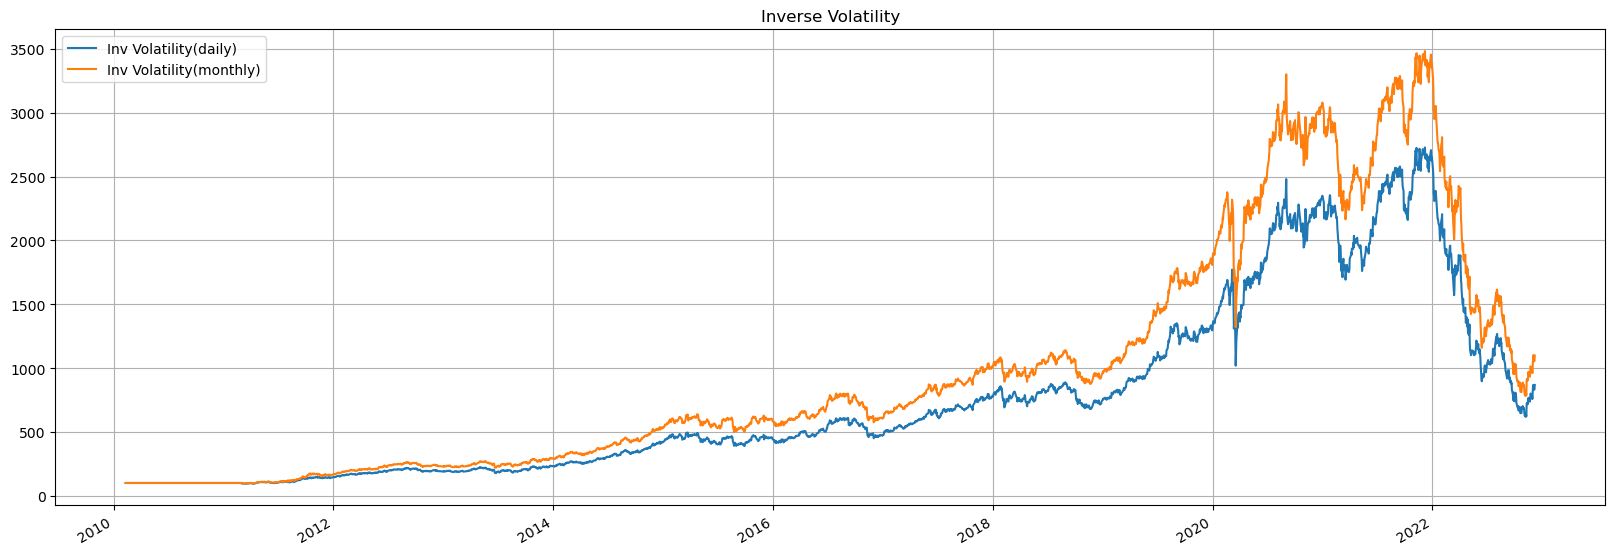

In [33]:
invVol_report.plot(figsize=(20,7), grid=True, title='Inverse Volatility')

In [34]:
#invVol_report.prices[start_day:].calc_stats().display()
invVol_report.set_date_range(start_day)
invVol_report.display()

Stat                 Inv Volatility(daily)    Inv Volatility(monthly)
-------------------  -----------------------  -------------------------
Start                2011-02-10               2011-02-10
End                  2022-12-07               2022-12-07
Risk-free rate       0.00%                    0.00%

Total Return         767.94%                  998.33%
Daily Sharpe         0.75                     0.81
Daily Sortino        1.19                     1.29
CAGR                 20.06%                   22.47%
Max Drawdown         -77.29%                  -77.56%
Calmar Ratio         0.26                     0.29

MTD                  8.22%                    8.42%
3m                   -10.09%                  -10.64%
6m                   -24.25%                  -25.74%
YTD                  -67.01%                  -67.30%
1Y                   -68.18%                  -68.47%
3Y (ann.)            -12.26%                  -14.69%
5Y (ann.)            2.74%                    2.27%
10

In [35]:
print(invVol_report.prices)

            Inv Volatility(daily)  Inv Volatility(monthly)
2011-02-10             100.000000               100.000000
2011-02-11             100.000000               100.000000
2011-02-14             100.000000               100.000000
2011-02-15             100.000000               100.000000
2011-02-16             100.000000               100.000000
...                           ...                      ...
2022-12-01             852.517411              1081.707177
2022-12-02             868.288735              1101.124303
2022-12-05             830.659245              1053.267420
2022-12-06             833.551581              1055.704496
2022-12-07             867.935492              1098.334976

[2977 rows x 2 columns]
